In [8]:
import numpy as np
import tensorflow as tf
import random
import math
import h5py
import gc
import sys
import pickle
import matplotlib.pyplot as plt

In [3]:
def acc(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [4]:
def randomize_dataset(images, labels):
    shuffle = list(zip(images, labels))
    np.random.shuffle(shuffle)
    i, l = zip(*shuffle)
    i, l = np.asarray(i), np.asarray(l)
    return i, l

In [5]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

In [6]:
hdf_file = 'datasets/pickles/SVHN_multi.hdf5'

hdf = h5py.File(hdf_file,'r')
test_dataset = hdf['test_images'][:]
test_labels = hdf['test_labels'][:]
train_dataset = hdf['train_images'][:]
train_labels = hdf['train_labels'][:]
valid_dataset = hdf['valid_images'][:]
valid_labels = hdf['valid_labels'][:]

hdf.close()       
    
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)

Training set (229089, 32, 96, 1) (229089, 6)
Test set (13068, 32, 96, 1) (13068, 6)
Validation set (6666, 32, 96, 1) (6666, 6)


In [11]:
def plot_img(image, title):
    plt.imshow(image)
    plt.title(title)
    plt.show()

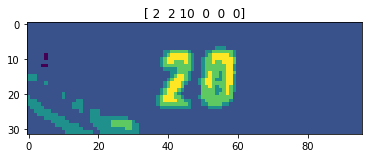

In [17]:
t_im = np.copy(test_dataset[670])
t_lb = np.copy(test_labels[670])

t_im = t_im[:,:,0]
plot_img(t_im, t_lb)

In [6]:
train_dataset = train_dataset.astype(np.float32)
test_dataset = test_dataset.astype(np.float32)
valid_dataset = valid_dataset.astype(np.float32)

train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)
valid_labels = valid_labels.astype(np.int32)

In [7]:
# train_dataset, train_labels = randomize_dataset(train_dataset, train_labels)
# test_dataset, test_labels = randomize_dataset(test_dataset, test_labels)
# valid_dataset, valid_labels = randomize_dataset(valid_dataset, valid_labels)

In [7]:
model_to_save = "saved_models/multi/CNN_SVHN_Multi.ckpt"

In [7]:
train_data = train_dataset
label_data = train_labels
print(train_data.shape, train_labels.shape)

(229089, 32, 96, 1) (229089, 6)


In [11]:
graph_svhn = tf.Graph()

with graph_svhn.as_default():
    HEIGHT = 32
    WIDTH = 32*3
    
    X = tf.placeholder(tf.float32, [None, HEIGHT, WIDTH, 1], name="X")
    Y_ = tf.placeholder(tf.int32, [None, 6], name="Y")
    
    # Learning Rate - alpha
    alpha = tf.placeholder(tf.float32)
    
    # Dropout Probablity
    pkeep = tf.placeholder(tf.float32)
    
    # 5 Layers and their no of neurons
    # 3 Convolutional Layers and a fully connected layer
    K = 6     # First Conv Layer with depth 6
    L = 12     # Second Conv Layer with depth 12
    M = 24    # Third Conv layer with depth 24
    N = 200   # Fourth Fully Connected layer with 200 neurons
    # Last one will be softmax layer with 10 output channels
    
    W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1), name="W1")    # 6x6 patch, 1 input channel, K output channels
    B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]), name="B1")
    
    W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1), name="W2")
    B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]), name="B2")
    
    W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1), name="W3")
    B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]), name="B3")
    
    W5_1 = tf.Variable(tf.truncated_normal([N, 11], stddev=0.1), name="W5_1")
    B5_1 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_1")
    
    W5_2 = tf.Variable(tf.truncated_normal([N, 11], stddev=0.1), name="W5_2")
    B5_2 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_2")
    
    W5_3 = tf.Variable(tf.truncated_normal([N, 11], stddev=0.1), name="W5_3")
    B5_3 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_3")
    
    W5_4 = tf.Variable(tf.truncated_normal([N, 11], stddev=0.1), name="W5_4")
    B5_4 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_4")
    
    W5_5 = tf.Variable(tf.truncated_normal([N, 11], stddev=0.1), name="W5_5")
    B5_5 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_5")
    
    # Model
    stride = 1  # output is 32x96
    Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
    
    stride = 2  # output is 16x48
    Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
    
    stride = 2  # output is 8x24
    Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

    # reshape the output from the third convolution for the fully connected layer
    shape = Y3.get_shape().as_list()
    YY = tf.reshape(Y3, shape=[-1, shape[1] * shape[2] * shape[3]])
    
    W4 = tf.Variable(tf.truncated_normal([shape[1] * shape[2] * shape[3], N], stddev=0.1), name="W4")
    B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]), name="B4")

    Y4 = tf.sigmoid(tf.matmul(YY, W4) + B4)
    YY4 = tf.nn.dropout(Y4, pkeep)
    
    Ylogits_1 = tf.matmul(YY4, W5_1) + B5_1
    Ylogits_2 = tf.matmul(YY4, W5_2) + B5_2
    Ylogits_3 = tf.matmul(YY4, W5_3) + B5_3
    Ylogits_4 = tf.matmul(YY4, W5_4) + B5_4
    Ylogits_5 = tf.matmul(YY4, W5_5) + B5_5   
    ## ('Ylogits_1 shape : ', [None, 11])
    
    Y_1 = tf.nn.softmax(Ylogits_1)
    Y_2 = tf.nn.softmax(Ylogits_2)
    Y_3 = tf.nn.softmax(Ylogits_3)
    Y_4 = tf.nn.softmax(Ylogits_4)
    Y_5 = tf.nn.softmax(Ylogits_5)

#     tf.summary.histogram("W1_summ", W1)
#     tf.summary.histogram("W2_summ", W2)
#     tf.summary.histogram("W3_summ", W3)
#     tf.summary.histogram("W4_summ", W4)
#     tf.summary.histogram("W5_1_summ", W5_1)
#     tf.summary.histogram("W5_2_summ", W5_2)
#     tf.summary.histogram("W5_3_summ", W5_3)
#     tf.summary.histogram("W5_4_summ", W5_4)
#     tf.summary.histogram("W5_5_summ", W5_5)

#     tf.summary.scalar('W1', W1)
#     tf.summary.scalar('W2', W2)
#     tf.summary.scalar('W3', W3)
#     tf.summary.scalar('W4', W4)
    

    with tf.name_scope('cross_entropy'):
        cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_1, Y_[:,1])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_2, Y_[:,2])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_3, Y_[:,3])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_4, Y_[:,4])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_5, Y_[:,5]))
#     tf.summary.scalar('cross_entropy', cross_entropy)
    
    train_prediction = tf.pack([Y_1, Y_2, Y_3, Y_4, Y_5])
    
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(alpha).minimize(cross_entropy)
    
    W_s = tf.pack([tf.reduce_max(tf.abs(W1)),tf.reduce_max(tf.abs(W2)),tf.reduce_max(tf.abs(W3)),tf.reduce_max(tf.abs(W4))])
    b_s = tf.pack([tf.reduce_max(tf.abs(B1)),tf.reduce_max(tf.abs(B2)),tf.reduce_max(tf.abs(B3)),tf.reduce_max(tf.abs(B4))])
    
#     merged = tf.summary.merge_all()
#     train_writer = tf.train.SummaryWriter(FLAGS.summaries_dir + '/train',sess.graph)
    
    model_saver = tf.train.Saver()

In [12]:
print('train : ', train_data.shape, '  test : ', label_data.shape)

batch_size = 128
num_steps = int(label_data.shape[0] / batch_size)
print(num_steps)

with tf.Session(graph=graph_svhn) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    
#     train_writer = tf.summary.FileWriter("tf_logs/", graph_svhn)
    
    for step in range(num_steps-1):
        #  learning rate decay
        max_learning_rate = 0.0005
        min_learning_rate = 0.0001

        decay_speed = 5000.0
        learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-step/decay_speed)
        
#         offset = (step * batch_size) % (label_data.shape[0] - batch_size)
#         batch_data = train_data[offset:(offset + batch_size), :, :, :]
#         batch_labels = label_data[offset:(offset + batch_size), :]
        batch_data = train_data[step*batch_size:(step + 1)*batch_size, :, :, :]
        batch_labels = label_data[step*batch_size:(step + 1)*batch_size, :]
        

        feed_dict = {X : batch_data, Y_ : batch_labels, pkeep : 0.80, alpha : learning_rate}
        _, l, train_pred, W, b = session.run([train_step, cross_entropy, train_prediction, W_s, b_s], feed_dict=feed_dict)
    
#         train_writer.add_summary(summary, step)
    
        if (step % 500 == 0):
            print('W : ', W)
            print('b : ', b)
            print('Loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % acc(train_pred, batch_labels[:,1:6]))
            print('Learning rate : ', learning_rate)
            print('    ')
            
    print('Training Complete on MNIST Data')
    
    save_path = model_saver.save(session, model_to_save)
    print("Model saved in file: %s" % save_path)

train :  (229089, 32, 96, 1)   test :  (229089, 6)
1789
Initialized
W :  [ 0.19626905  0.19794394  0.19991484  0.1999965 ]
b :  [ 0.1  0.1  0.1  0.1]
Loss at step 0: 14.987848
Minibatch accuracy: 5.8%
Learning rate :  0.0005
    
W :  [-inf -inf -inf -inf]
b :  [-inf -inf -inf -inf]
Loss at step 500: nan
Minibatch accuracy: 48.0%
Learning rate :  0.00046193496721438383
    


KeyboardInterrupt: 

In [12]:
print('train : ', train_data.shape, '  test : ', label_data.shape)

num_steps_1 = 15001
batch_size = 128

with tf.Session(graph=graph_svhn) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    
    for step in range(num_steps_1):
        #  learning rate decay
        max_learning_rate = 0.0005
        min_learning_rate = 0.0001

        decay_speed = 5000.0
        learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-step/decay_speed)
        offset = (step * batch_size) % (label_data.shape[0] - batch_size)
        batch_data = train_data[offset:(offset + batch_size), :, :, :]
        batch_labels = label_data[offset:(offset + batch_size), :]
        
        feed_dict = {X : batch_data, Y_ : batch_labels, pkeep : 0.80, alpha : learning_rate}
        _, l, train_pred, W, b = session.run([train_step, cross_entropy, train_prediction, W_s, b_s], feed_dict=feed_dict)
    
        if (step % 500 == 0):
            print('W : ', W)
            print('b : ', b)
            print('Loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % acc(train_pred, batch_labels[:,1:6]))
            print('Learning rate : ', learning_rate)
            print('    ')
            
    print('Training Complete on MNIST Data')
    
    save_path = model_saver.save(session, model_to_save)
    print("Model saved in file: %s" % save_path)

train :  (125000, 32, 96, 1)   test :  (125000, 6)
Initialized
W :  [ 0.19254409  0.19941452  0.19995373  0.19999591]
b :  [ 0.1  0.1  0.1  0.1]
Loss at step 0: 14.082214
Minibatch accuracy: 4.4%
Learning rate :  0.0005
    
W :  [-inf -inf -inf -inf]
b :  [-inf -inf -inf -inf]
Loss at step 500: nan
Minibatch accuracy: 49.1%
Learning rate :  0.00046193496721438383
    


KeyboardInterrupt: 

In [ ]:
with tf.Session(graph=graph_svhn) as session: 
    print('Initialized')
    batch = 1000
    
    test_acc = list()
    print('-------TEST--------')
    test_no = int(test_labels.shape[0] / batch)
    for i in range(test_no - 1):
        model_saver.restore(session, model_to_save)
        data = test_dataset[i*batch:(i+1)*batch]
        labels = test_labels[i*batch:(i+1)*batch]
        
        _, l, predictions = session.run([train_step, cross_entropy, train_prediction], feed_dict={X : data, Y_ : labels, pkeep : 1.0, alpha : 0.002})
        accuracy = acc(predictions, labels[:,1:6])
        test_acc.append(accuracy)
        
        print('Test-Accuracy', ' i : ', i)
        print('Test accuracy: ', accuracy)
        print('       ')
        
        
    valid_acc = list()
    print('-----VALIDIDATION------')
    valid_no = int(valid_labels.shape[0] /  batch)
    for i in range(valid_no - 1):
        model_saver.restore(session, "saved_models/box/CNN_SVHN_Box.ckpt")
        data = valid_dataset[i*batch:(i+1)*batch]
        labels = valid_labels[i*batch:(i+1)*batch]
        
        _, l, predictions = session.run([train_step, cross_entropy, train_prediction], feed_dict={X : data, Y_ : labels, pkeep : 1.0, alpha : 0.002})
        accuracy = acc(predictions, labels[:,1:6])
        valid_acc.append(accuracy)
        
        print('Valid-Accuracy', ' i : ', i)
        print('Valid accuracy: ', accuracy)
        print('        ')
        
        
    test_avg = mean(test_acc)
    valid_avg = mean(valid_acc)
    
    print('-----  FINAL  ------')
    print('Final Test Set Accuracy : ',"%.2f" % test_avg)
    print('Final Validation Set Accuracy : ',"%.2f" % valid_avg)

In [ ]:
train_data = train_dataset
label_data = train_labels
print('train : ', train_data.shape, '  test : ', label_data.shape)

num_steps_1 = 25001
batch_size = 128

with tf.Session(graph=graph_svhn) as session:
    model_saver.restore(session, model_to_save)
    print('Initialized')
    
    W1 = session.run(W1)
    print(W1)